# Caclulate a Set of Descriptors and Create Plots
     
* Create per-class and overview plots

In [1]:
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to silence scikit-learn warnings

import warnings
warnings.filterwarnings('ignore')
warnings.warn = warn

# Type hints
from typing import Iterable, List, Set, Dict, Union, Optional

import os, gc
import time

import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem, QED
from rdkit.Chem import Descriptors as Desc
from rdkit.Chem import rdMolDescriptors as rdMolDesc
from rdkit.Chem import Fragments

from Contrib.NP_Score import npscorer

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Project-local Imports
from jupy_tools import plt_style, pca
from jupy_tools import utils as u, mol_view as mv
from jupy_tools.utils import info
time_start = time.time()
u.timestamp()

Timestamp: 25-May-2023 14:34:01


## Functions

In [2]:
pca_xlim = (-5, 6)  # (-6, 8)
pca_ylim = (-5, 5)  # (-6, 5)

def pca_plot_overview(df, comp: List[int]):
    plt.figure(figsize=(15, 14));
    fig, ax = plt.subplots();
    leg_dict = {}
    leg_list = ["Enamine", "DrugBank", "ChEMBL NP", config["name"]]
    plot_order = ["DrugBank", "ChEMBL NP", "Enamine"]
    for ds in plot_order:
        # tmp1 = df.query(f"""DataSet == '{ds}'""").sample(n=2500).copy().reset_index(drop=True)
        tmp1 = df.query(f"""DataSet == '{ds}'""").copy().reset_index(drop=True)
        x = tmp1[f"Comp_{comp[0]}"]
        y = tmp1[f"Comp_{comp[1]}"]

        quant_low = tmp1.quantile(0.05)
        xmin = round(2 * quant_low[f"Comp_{comp[0]}"], 0) / 2 - 3.0
        ymin = round(2 * quant_low[f"Comp_{comp[1]}"], 0) / 2 - 3.0
        quant_high = tmp1.quantile(0.95)
        xmax = round(2 * quant_high[f"Comp_{comp[0]}"], 0) / 2 + 3.0
        ymax = round(2 * quant_high[f"Comp_{comp[1]}"], 0) / 2 + 3.0

        # Peform the kernel density estimate
        xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
        positions = np.vstack([xx.ravel(), yy.ravel()]).T
        values = np.vstack([x, y]).T
        kde = KernelDensity(
            algorithm="kd_tree",
            kernel='gaussian', bandwidth=.4,
        ).fit(values)
        f = np.reshape(
            np.exp(kde.score_samples(positions)), 
            xx.shape
        )

        # Contour plot
        cntr = ax.contour(xx, yy, f, colors=cmap[ds], levels=10, label=ds, linestyles="-", linewidths=2.0);
        leg_elem,_ = cntr.legend_elements()
        leg_dict[ds] = leg_elem[7]
        # scatter = ax.plot(x, y, 'o', markersize=4, alpha=0.7, color=cmap[ds])

    # Overview plot for the internal DataSet
    tmp2 = df.query(f"""DataSet == '{config["name"]}'""")
    x = tmp2[f"Comp_{comp[0]}"]
    y = tmp2[f"Comp_{comp[1]}"]
    scatter = ax.plot(x, y, 'o', markersize=7, color=cmap[config["name"]])
    leg_dict[config["name"]] = scatter[0]

    plt.xlim(pca_xlim);
    plt.ylim(pca_ylim);
    plt.xlabel(f"PC{comp[0]}");
    plt.ylabel(f"PC{comp[1]}");
    leg_elements = [leg_dict[x] for x in leg_list]
    plt.legend(leg_elements, leg_list);
    plt.title(f"PCA Comp{comp[0]} and Comp{comp[1]}");
    plt.savefig(f"{config['dataset']}/output/pca_{comp[0]}_{comp[1]}.png");
    plt.savefig(f"{config['dataset']}/output/pca_{comp[0]}_{comp[1]}.svg");

def pca_plot_per_class(df, comp: List[int]):
    plt.figure(figsize=(15, 14));
    fig, ax = plt.subplots();
    leg_dict = {}
    leg_list = ["Enamine", "DrugBank", "ChEMBL NP"]
    plot_order = ["DrugBank", "ChEMBL NP", "Enamine"]
    for ds in plot_order:
        # tmp1 = df.query(f"""DataSet == '{ds}'""").sample(n=2500).copy().reset_index(drop=True)
        tmp1 = df.query(f"""DataSet == '{ds}'""").copy().reset_index(drop=True)
        x = tmp1[f"Comp_{comp[0]}"]
        y = tmp1[f"Comp_{comp[1]}"]

        quant_low = tmp1.quantile(0.05)
        xmin = round(2 * quant_low[f"Comp_{comp[0]}"], 0) / 2 - 3.0
        ymin = round(2 * quant_low[f"Comp_{comp[1]}"], 0) / 2 - 3.0
        quant_high = tmp1.quantile(0.95)
        xmax = round(2 * quant_high[f"Comp_{comp[0]}"], 0) / 2 + 3.0
        ymax = round(2 * quant_high[f"Comp_{comp[1]}"], 0) / 2 + 3.0

        # Peform the kernel density estimate
        xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
        positions = np.vstack([xx.ravel(), yy.ravel()]).T
        values = np.vstack([x, y]).T
        kde = KernelDensity(
            algorithm="kd_tree",
            kernel='gaussian', bandwidth=.4,
        ).fit(values)
        f = np.reshape(
            np.exp(kde.score_samples(positions)), 
            xx.shape
        )

        # Contour plot
        cntr = ax.contour(xx, yy, f, colors=cmap[ds], levels=10, label=ds, linestyles="-", linewidths=2.0);
        leg_elem,_ = cntr.legend_elements()
        leg_dict[ds] = leg_elem[7]
        # scatter = ax.plot(x, y, 'o', markersize=4, alpha=0.7, color=cmap[ds])

    # Per-class plots for the internal DataSet
    markers = ["o", "^", "s", "p", "P", "*", "X", "<", ">", "D", "v"]
    assert len(markers) == len(set(markers)), "Markers are not unique."
    tmp2 = df.query(f"""DataSet == '{config["name"]}'""")
    reverse_order = not config.get("per_class_order_asc", True)
    cpd_classes = list(sorted(tmp2["CpdClass"].unique(), reverse=reverse_order))
    assert len(cpd_classes) <= len(markers), "Not enough markers for the number of classes."
    class_marker_colors = config.get("per_class_colors", None)
    for idx, cc in enumerate(cpd_classes):
        tmp_cc = tmp2.query(f"""CpdClass == '{cc}'""").copy().reset_index(drop=True)
        x = tmp_cc[f"Comp_{comp[0]}"]
        y = tmp_cc[f"Comp_{comp[1]}"]
        if class_marker_colors is None:
            scatter = ax.plot(x, y, markers[idx], markersize=10, color=cmap[config["name"]])
        else:
            scatter = ax.plot(x, y, markers[idx], markersize=10, color=class_marker_colors[idx])
        leg_list.append(cc)
        leg_dict[cc] = scatter[0]

    plt.xlim(pca_xlim);
    plt.ylim(pca_ylim);
    plt.xlabel(f"PC{comp[0]}");
    plt.ylabel(f"PC{comp[1]}");
    leg_elements = [leg_dict[x] for x in leg_list]
    plt.legend(leg_elements, leg_list);
    plt.title(f"PCA Comp{comp[0]} and Comp{comp[1]} (per class)");
    plt.savefig(f"{config['dataset']}/output/pca_per_class_{comp[0]}_{comp[1]}.png");
    plt.savefig(f"{config['dataset']}/output/pca_per_class_{comp[0]}_{comp[1]}.svg");

def lip_classic():
    df_int = u.read_tsv(f"{config['dataset']}/output/descriptors.tsv")
    tmp = df_int.copy()
    plt.figure(figsize=(15, 14));
    fig, ax = plt.subplots();
    leg_dict = {}
    leg_list = []
    markers = ["o", "^", "s", "p", "P", "*", "X", "<", ">", "D", "v"]
    assert len(markers) == len(set(markers)), "Markers are not unique."
    cpd_classes = list(sorted(tmp["CpdClass"].unique()))
    assert len(cpd_classes) <= len(markers), "Not enough markers for the number of classes."
    class_marker_colors = config.get("per_class_colors", None)
    plt.plot([0, 500, 500], [5, 5, 0], color="k", linestyle="-")
    for idx, cc in enumerate(cpd_classes):
        tmp_cc = tmp.query(f"""CpdClass == '{cc}'""")
        x = tmp_cc["MW"]
        y = tmp_cc["LogP"]
        if class_marker_colors is None:
            scatter = ax.plot(x, y, markers[idx], markersize=10, color=cmap[config["name"]])
        else:
            scatter = ax.plot(x, y, markers[idx], markersize=10, color=class_marker_colors[idx])
        leg_list.append(cc)
        leg_dict[cc] = scatter[0]
    plt.xlim((0, 800))
    plt.ylim(0, 8)
    plt.xlabel("MW");
    plt.ylabel("LogP");
    leg_elements = [leg_dict[x] for x in leg_list]
    plt.legend(leg_elements, leg_list);
    plt.title("LogP vs. MW");
    out_fn = f"{config['dataset']}/output/lip_classic"
    plt.savefig(f"{out_fn}.png");
    plt.savefig(f"{out_fn}.svg");

## Configuration

In [3]:
config = {
    "dataset": "desc",
    "name": "PNPs",
    "id_col": "ENSO_Id",  # this key is optional
    "extra_columns": [],
    "has_cpd_ids": False,
    "per_class_plots": True,
    "per_class_order_asc": True,
}

In [4]:

DATA_EN = "enamine_adv_full"
DATA_DB = "drugbank_5.1.8_appr_inv_full"
DATA_NP = "chembl_30_np_full_nocanon_deglyco"

descriptors = {
    "NP_Like": lambda x: round(score_np(x), 2), 
    "QED": lambda x: round(QED.default(x), 3),
    "NumHA": lambda x: x.GetNumAtoms(),
    "MW": lambda x: round(Desc.ExactMolWt(x), 2),
    "NumRings": rdMolDesc.CalcNumRings,
    "NumRingsArom": rdMolDesc.CalcNumAromaticRings,
    "NumRingsAli": rdMolDesc.CalcNumAliphaticRings,
    "NumHDon": rdMolDesc.CalcNumLipinskiHBD,
    "NumHAcc": rdMolDesc.CalcNumLipinskiHBA,
    "LogP": lambda x: round(Desc.MolLogP(x), 2),
    "TPSA": lambda x: round(rdMolDesc.CalcTPSA(x), 2),
    "NumRotBd": rdMolDesc.CalcNumRotatableBonds,
    "NumAtOx": lambda x: len(
        [a for a in x.GetAtoms() if a.GetAtomicNum() == 8]
    ),
    "NumAtN": lambda x: len(
        [a for a in x.GetAtoms() if a.GetAtomicNum() == 7]
    ),
    "NumAtHal": Fragments.fr_halogen,
    "NumAtBridgehead": rdMolDesc.CalcNumBridgeheadAtoms,
    "FCsp3": lambda x: round(rdMolDesc.CalcFractionCSP3(x), 3), 
}

print(f"Number of descriptors: {len(descriptors)}")

cmap = {"Enamine": "#1f77b4", "DrugBank": "#ff7f0e", "ChEMBL NP": "#2ca02c", config["name"]: "#000000"}
contour_cmap = {"Enamine": "#1f77b4", "DrugBank": "#ff7f0e", "ChEMBL NP": "#2ca02c", config["name"]: "#000000"}
# line_styles = {"Enamine": "dashed", "DrugBank": "dotted", "ChEMBL NP": "dashdot", config["name"]: "solid"}
line_styles = {"Enamine": "--", "DrugBank": ":", "ChEMBL NP": "-.", config["name"]: "-"}
# line_styles = [(5, 5), (1, 1), (3, 5, 1, 5), ()]
selected_descriptors = ["NP_Like", "QED", "FCsp3"]
xlims = {"NP_Like": (-5, 5), "QED": (0, 1), "FCsp3": (0, 1)}
widths = {"NP_Like": 10, "QED": 10, "FCsp3": 10}

fscore = npscorer.readNPModel()
def score_np(mol):
    return npscorer.scoreMol(mol, fscore)

os.makedirs(f'{config["dataset"]}/output', exist_ok=True)

Number of descriptors: 17


reading NP model ...
model in


## Loading Data Sets

In [5]:
df_int = u.read_tsv(f'{config["dataset"]}/input/smiles_all.tsv')

if config["has_cpd_ids"]:
    # Merge structure Smiles by Compound_Id
    config["id_col"] = "Compound_Id"
    df_comas = u.read_tsv("/home/pahl/comas/share/comas_smiles.tsv")
    num_cpds_1 = len(df_int)
    df_int = pd.merge(df_int, df_comas, on="Compound_Id", how="left")
    num_cpds_2 = len(df_int)
    assert num_cpds_1 == num_cpds_2, f"Only {num_cpds_2} out of {num_cpds_2} compounds were found in the COMAS database."
if config.get("has_salts", False):
    print("Standardizing structures...")
    num_cpds_1 = len(df_int)
    df_int = u.calc_from_smiles(df_int, "Smiles_Stand", u.standardize_mol)
    df_int = u.remove_nans(df_int, "Smiles_Stand")
    num_cpds_2 = len(df_int)
    assert num_cpds_1 == num_cpds_2, f"Only {num_cpds_2} out of {num_cpds_1} compounds could be standardized."
    df_int = df_int.drop("Smiles", axis=1)
    df_int = df_int.rename(columns={'Smiles_Stand': 'Smiles'})
if "id_col" not in config:
    config["id_col"] = "Cpd_Id"
    df_int["Cpd_Id"] = df_int.index + 1

# The reference data sets already contain the Descriptor data
# Generated by the separate notebook `01_desc_precalc_datasets`
df_en = u.read_tsv(f"input/{DATA_EN}_sample_50k_desc.tsv")
df_db = u.read_tsv(f"input/{DATA_DB}_desc.tsv")
df_np = u.read_tsv(f"input/{DATA_NP}_desc.tsv")

datasets = {"Enamine": df_en, "DrugBank": df_db, "ChEMBL NP": df_np}
id_cols = {"Enamine": "idnumber", "DrugBank": "DRUGBANK_ID", "ChEMBL NP": "chembl_id", config["name"]: config["id_col"]}

read_tsv                           : [     153 /   3 ] ( CpdClass, ENSO_Id, Smiles )
read_tsv                           : [   50000 /  28 ] 
read_tsv                           : [    4866 /  21 ] 
read_tsv                           : [   45679 /  20 ] 


## Write Structure Overview File

In [6]:
mv.write_mol_grid(
    df_int, title=config["name"], id_col="Cpd_Id", fn=f"{config['dataset']}/output/mol_grid.html",
    truncate=20
)

drop_cols                          : [     153 /   3 ]  1 columns removed. ( CpdClass, ENSO_Id, Mol )


## Adding Descriptors to Internal Data
Make sure that the above list of descriptors is identical to that of `2203_02_calc_desc.ipynb`.

In [7]:
for desc in descriptors:
    print(f"{desc:15}: ")
    df_int = u.calc_from_smiles(df_int, desc, descriptors[desc])
datasets[config["name"]] = df_int
u.write_tsv(df_int, f"{config['dataset']}/output/descriptors.tsv")

NP_Like        : 
calc_from_smiles                   : [     153 /   4 ]    0 rows removed because of nans. ( CpdClass, ENSO_Id, Smiles, NP_Like )
QED            : 
calc_from_smiles                   : [     153 /   5 ]    0 rows removed because of nans. ( CpdClass, ENSO_Id, Smiles, NP_Like, QED )
NumHA          : 
calc_from_smiles                   : [     153 /   6 ]    0 rows removed because of nans. ( CpdClass, ENSO_Id, Smiles, NP_Like, QED, NumHA )
MW             : 
calc_from_smiles                   : [     153 /   7 ]    0 rows removed because of nans. ( CpdClass, ENSO_Id, Smiles, NP_Like, QED, NumHA, MW )
NumRings       : 
calc_from_smiles                   : [     153 /   8 ]    0 rows removed because of nans. ( CpdClass, ENSO_Id, Smiles, NP_Like, QED, NumHA, MW, NumRings )
NumRingsArom   : 
calc_from_smiles                   : [     153 /   9 ]    0 rows removed because of nans. ( CpdClass, ENSO_Id, Smiles, NP_Like, QED, NumHA, MW, NumRings, NumRingsArom )
NumRingsAli    : 
c

## Generate One Data Set for Plotting

In [8]:
tmp_list = []
for ds in datasets:
    tmp = datasets[ds].copy()
    tmp["DataSet"] = ds
    tmp = tmp.rename(columns={id_cols[ds]: "Cpd_Id"})
    tmp_list.append(tmp)

cols = ["Cpd_Id", "DataSet"]
cols.extend(config["extra_columns"])
cols.extend(descriptors.keys())
if config["per_class_plots"]:
    cols.append("CpdClass")
df_all = pd.concat(tmp_list)[cols]
df_all = df_all.reset_index(drop=True)
del tmp_list

## Analysis
### Overview Plots NP-Likeness, QED
### ECDF

In [9]:
datasets.keys()

dict_keys(['Enamine', 'DrugBank', 'ChEMBL NP', 'PNPs'])

In [10]:
for desc in selected_descriptors:
    plt.figure(figsize=(widths[desc], 7))
    for ds in datasets:
        tmp = df_all[df_all["DataSet"] == ds].copy()
        sns.ecdfplot(data=tmp, x=desc, stat="proportion", color=cmap[ds], linestyle=line_styles[ds])
    plt.xlim(xlims[desc]);
    plt.legend(datasets.keys(), title='DataSet')
    plt.title(f"Distribution of {desc}")
    plt.savefig(f"{config['dataset']}/output/ecdf_overview_{desc}.png");
    plt.savefig(f"{config['dataset']}/output/ecdf_overview_{desc}.svg");
    plt.clf()
    plt.close()
    gc.collect()

<Figure size 1000x700 with 0 Axes>

<AxesSubplot: xlabel='NP_Like', ylabel='Proportion'>

<AxesSubplot: xlabel='NP_Like', ylabel='Proportion'>

<AxesSubplot: xlabel='NP_Like', ylabel='Proportion'>

<AxesSubplot: xlabel='NP_Like', ylabel='Proportion'>

(-5.0, 5.0)

Text(0.5, 1.0, 'Distribution of NP_Like')

487

<Figure size 1000x700 with 0 Axes>

<AxesSubplot: xlabel='QED', ylabel='Proportion'>

<AxesSubplot: xlabel='QED', ylabel='Proportion'>

<AxesSubplot: xlabel='QED', ylabel='Proportion'>

<AxesSubplot: xlabel='QED', ylabel='Proportion'>

(0.0, 1.0)

Text(0.5, 1.0, 'Distribution of QED')

2943

<Figure size 1000x700 with 0 Axes>

<AxesSubplot: xlabel='FCsp3', ylabel='Proportion'>

<AxesSubplot: xlabel='FCsp3', ylabel='Proportion'>

<AxesSubplot: xlabel='FCsp3', ylabel='Proportion'>

<AxesSubplot: xlabel='FCsp3', ylabel='Proportion'>

(0.0, 1.0)

Text(0.5, 1.0, 'Distribution of FCsp3')

2337

### Per-Class Plots NP-Likeness, QED

In [11]:
if config["per_class_plots"]:
    class_marker_colors = config.get("per_class_colors", None)
    reverse_order = not config.get("per_class_order_asc", True)
    cpd_classes = list(sorted(df_int["CpdClass"].unique(), reverse=reverse_order))
    print(cpd_classes)

    for desc in selected_descriptors:
        plt.figure(figsize=(widths[desc], 7))
        if class_marker_colors is None:
            sns.ecdfplot(data=df_int, x=desc, stat="proportion", hue="CpdClass")
        else:
            class_palette = {cpd_classes[idx]: class_marker_colors[idx] for idx in range(len(cpd_classes))}
            sns.ecdfplot(data=df_int, x=desc, stat="proportion", hue="CpdClass", palette=class_palette)
        plt.xlim(xlims[desc]);
        # plt.legend();
        plt.title(f"Distribution of {desc}")
        plt.savefig(f"{config['dataset']}/output/ecdf_perclass_{desc}.png");
        plt.savefig(f"{config['dataset']}/output/ecdf_perclass_{desc}.svg");
        plt.clf()
        plt.close()
        gc.collect()

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']


<Figure size 1000x700 with 0 Axes>

<AxesSubplot: xlabel='NP_Like', ylabel='Proportion'>

(-5.0, 5.0)

Text(0.5, 1.0, 'Distribution of NP_Like')

4400

<Figure size 1000x700 with 0 Axes>

<AxesSubplot: xlabel='QED', ylabel='Proportion'>

(0.0, 1.0)

Text(0.5, 1.0, 'Distribution of QED')

3328

<Figure size 1000x700 with 0 Axes>

<AxesSubplot: xlabel='FCsp3', ylabel='Proportion'>

(0.0, 1.0)

Text(0.5, 1.0, 'Distribution of FCsp3')

3326

### Descriptor PCA

In [12]:
n_comp = 3
desc_list = list(descriptors.keys())
df_all = df_all.reset_index(drop=True)
cols = ["Cpd_Id", "DataSet"]
cols.extend(config["extra_columns"])
if config["per_class_plots"]:
    cols.append("CpdClass")
df_comp = df_all[cols].copy()
df_data = df_all[desc_list].copy()
# df_data = minmax_scale(df_data, feature_range=(0, 1), axis=1)
df_data = StandardScaler().fit_transform(df_data)
pca_model = PCA(n_components=n_comp)
pca_result = pca_model.fit_transform(df_data)
variance = pd.DataFrame(
    [
        (f"PC{x+1}", 100 * pca_model.explained_variance_ratio_[x])
        for x in range(n_comp)
    ],
    columns=["Comp.", "Expl. Var. [%]"],
)
variance = variance.round(1)

df_comp["Comp_1"] = pca_result[:, 0]
df_comp["Comp_2"] = pca_result[:, 1]
df_comp["Comp_3"] = pca_result[:, 2]
u.write_tsv(df_comp.query(f"""DataSet == "{config['name']}" """), f"{config['dataset']}/output/pca_components.tsv")
u.write_tsv(variance, f"{config['dataset']}/output/pca_explained_variance.tsv")
variance

,Comp.,Expl. Var. [%]
0,PC1,40.7
1,PC2,19.8
2,PC3,10.1


#### PCA Overview Plots Comp1 to Comp3

<Figure size 1500x1400 with 0 Axes>

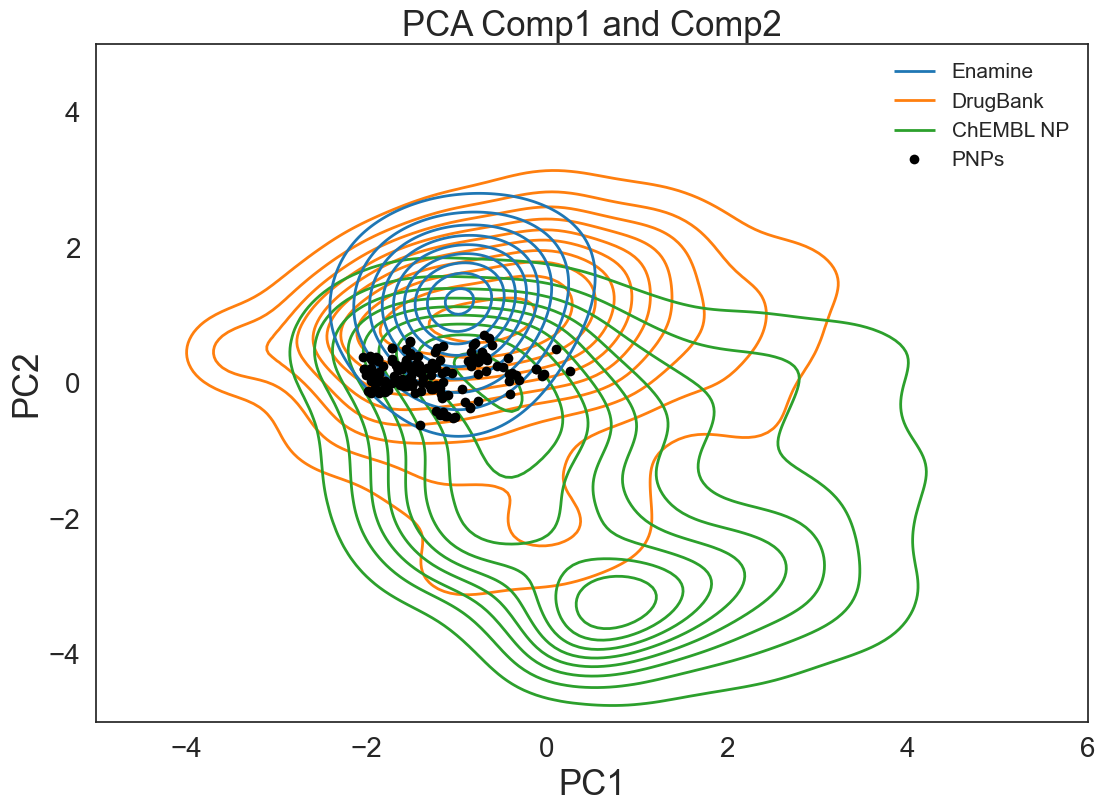

<Figure size 1500x1400 with 0 Axes>

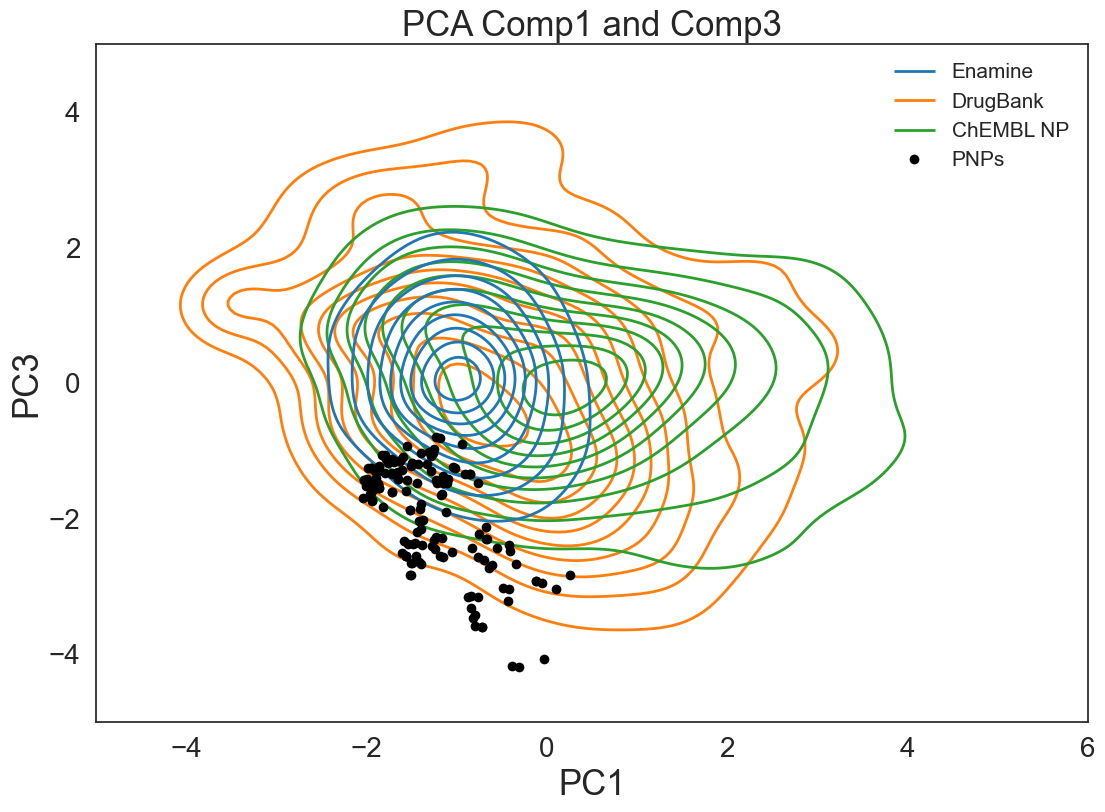

<Figure size 1500x1400 with 0 Axes>

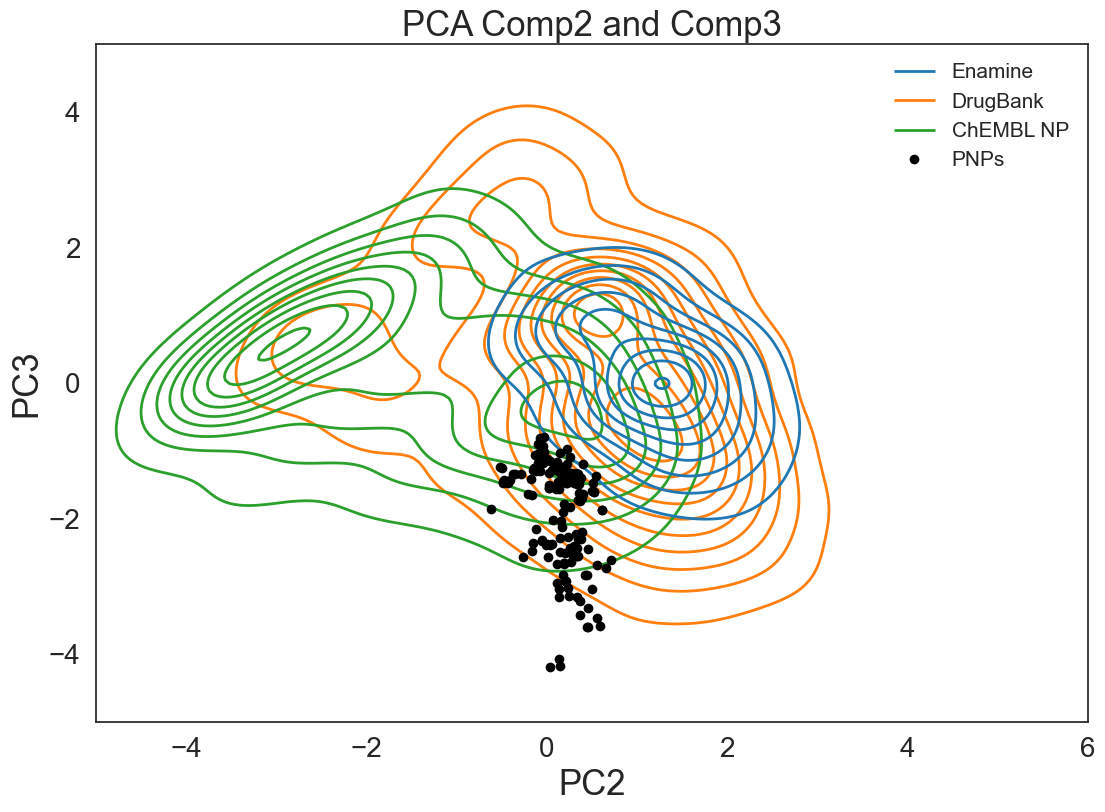

In [13]:
pca_plot_overview(df_comp, [1, 2])
pca_plot_overview(df_comp, [1, 3])
pca_plot_overview(df_comp, [2, 3])

#### PCA Per Class Plots Comp1 to Comp3

<Figure size 1500x1400 with 0 Axes>

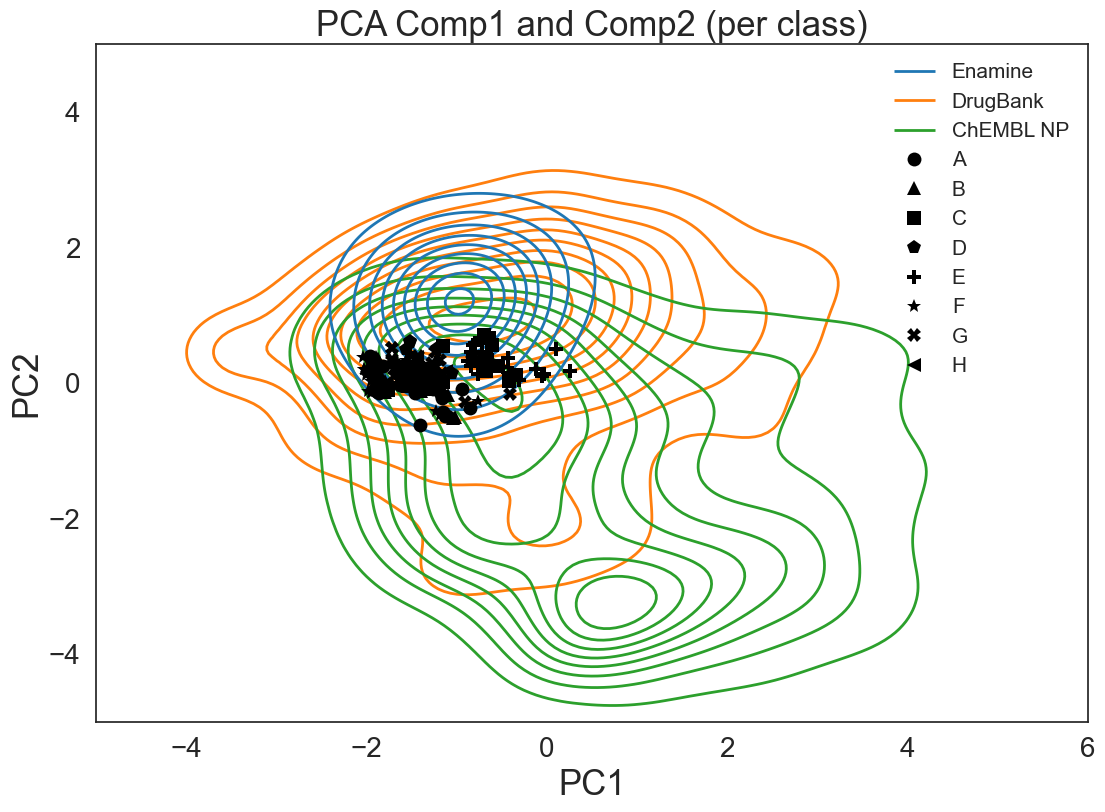

<Figure size 1500x1400 with 0 Axes>

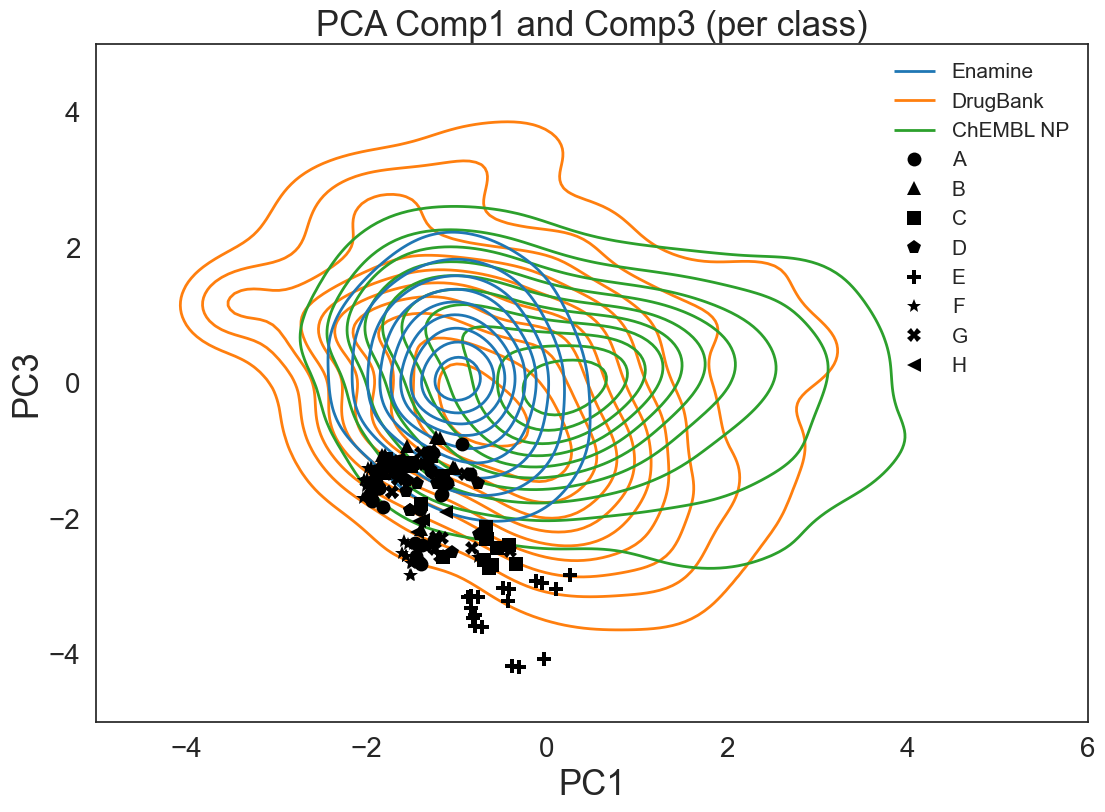

<Figure size 1500x1400 with 0 Axes>

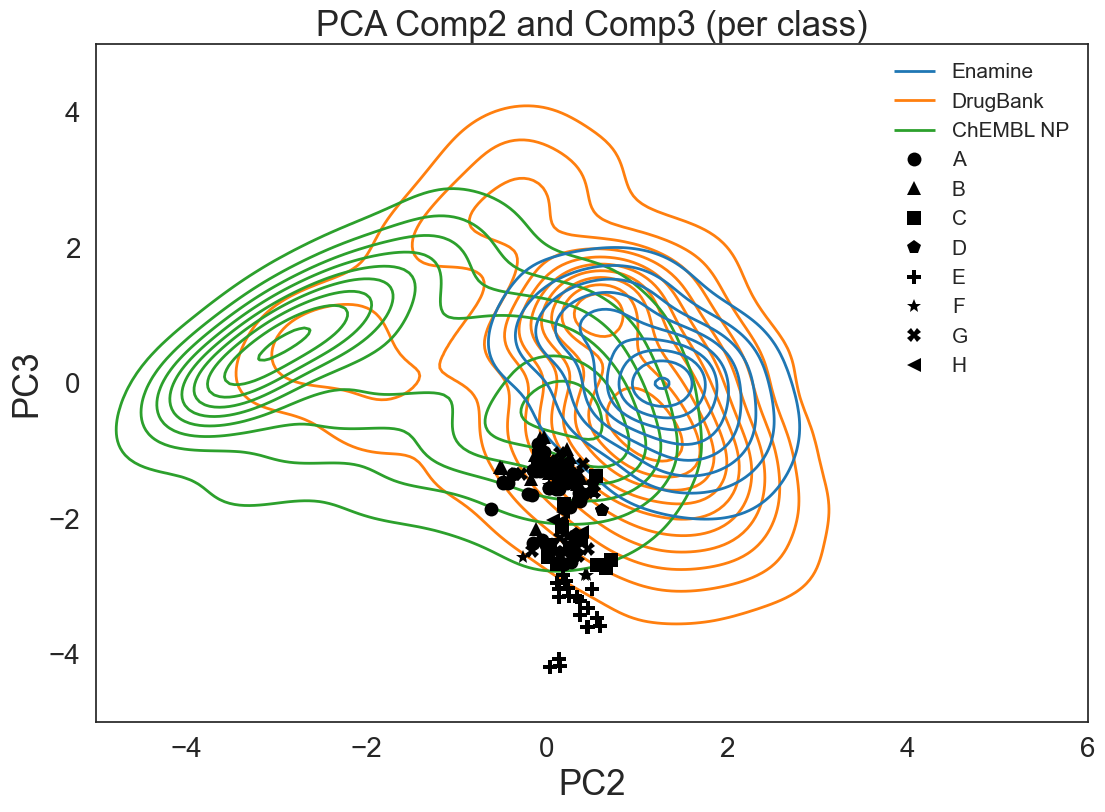

In [14]:
if config["per_class_plots"]:
    pca_plot_per_class(df_comp, [1, 2])
    pca_plot_per_class(df_comp, [1, 3])
    pca_plot_per_class(df_comp, [2, 3])

In [15]:
df_pca_feature_contrib = pca.get_pca_feature_contrib(pca_model, desc_list)
u.write_tsv(df_pca_feature_contrib, f"{config['dataset']}/output/pca_feature_contrib.tsv")
df_pca_feature_contrib
# u.open_in_localc(df_pca_feature_contrib)

,Feature,PC1_feature_contrib,PC2_feature_contrib,PC3_feature_contrib,PC1_rank,PC2_rank,PC3_rank,PC1_feature_contrib_cum_ratio,PC2_feature_contrib_cum_ratio,PC3_feature_contrib_cum_ratio
0,FCsp3,0.063311,0.340388,0.396042,14,4,3,0.959159,0.447676,0.463081
1,LogP,0.043371,0.258014,0.389430,17,6,4,1.000000,0.619736,0.589556
2,MW,0.366674,0.009542,0.061449,2,16,14,0.205330,0.999323,0.958054
3,NP_Like,0.106364,0.444600,0.050075,13,1,16,0.941454,0.128033,0.992720
4,NumAtBridgehead,0.123678,0.190433,0.195972,12,8,5,0.911709,0.739606,0.653202
5,NumAtHal,0.049291,0.152293,0.109672,16,11,8,0.987871,0.873417,0.806181
6,NumAtN,0.167633,0.371843,0.071785,10,3,12,0.832523,0.349653,0.915815
7,NumAtOx,0.337121,0.059115,0.022415,5,15,17,0.499907,0.996575,1.000000
8,NumHA,0.367558,0.002351,0.075376,1,17,11,0.102788,1.000000,0.892502
9,NumHAcc,0.355930,0.155936,0.056665,4,10,15,0.405630,0.829560,0.976457


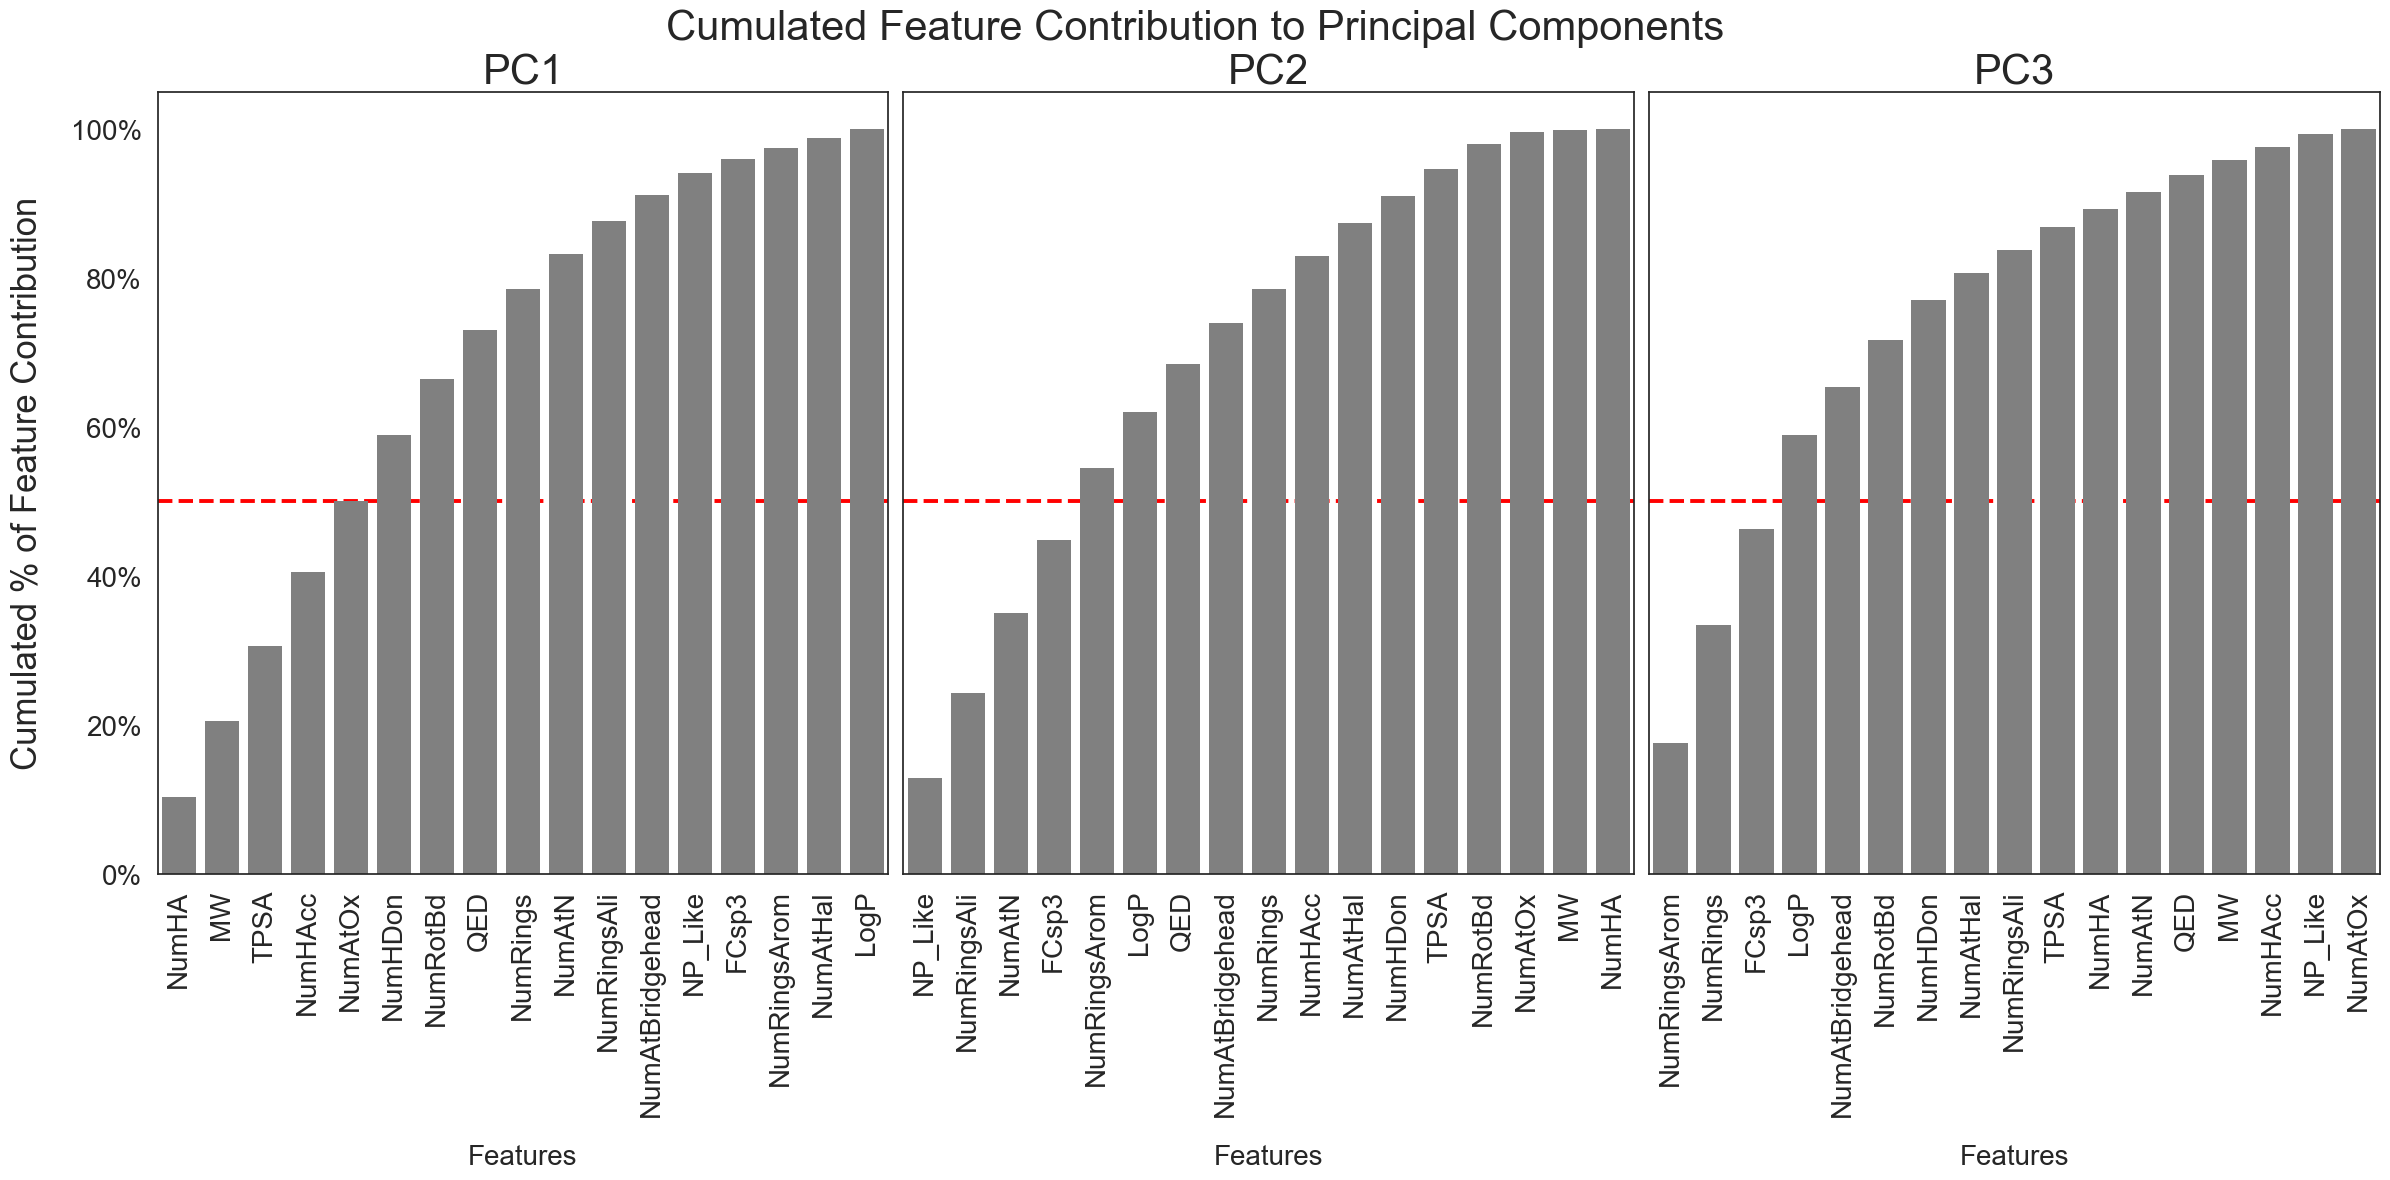

In [16]:
fig = pca.plot_pca_cum_feature_contrib_3pc(df_pca_feature_contrib)
fig.savefig(f"{config['dataset']}/output/pca_cum_feature_contrib.png", dpi=600)

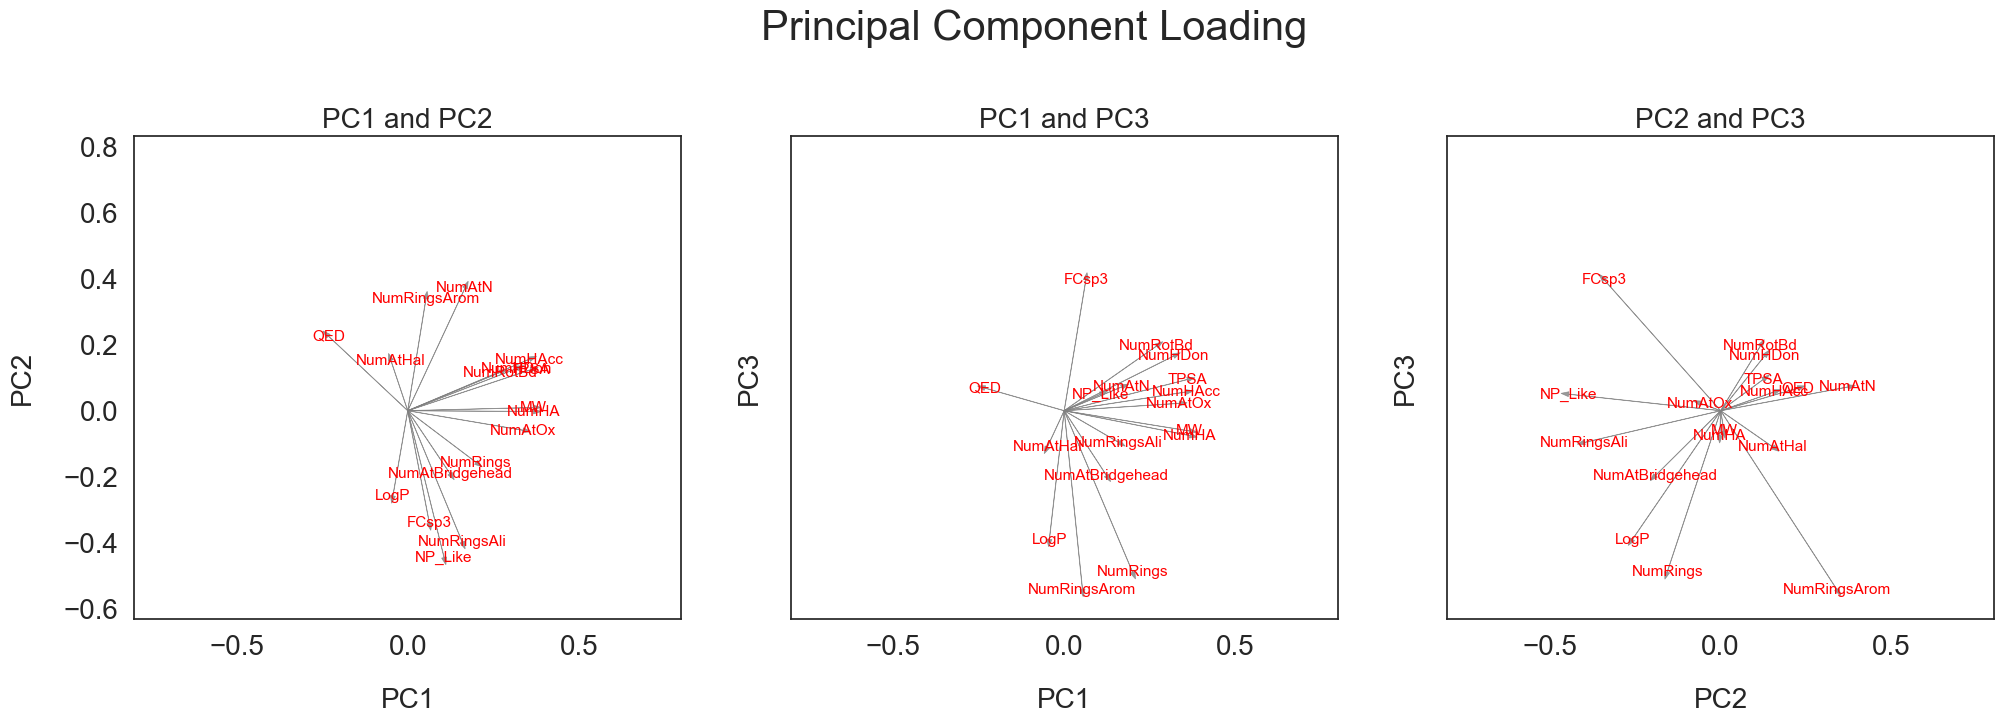

In [17]:
fig = pca.plot_pca_loadings_3pc(pca_model, pca_result, desc_list)
fig.savefig(f"{config['dataset']}/output/pca_component_loading.png", dpi=600)

read_tsv                           : [     153 /  20 ] 


<Figure size 1500x1400 with 0 Axes>

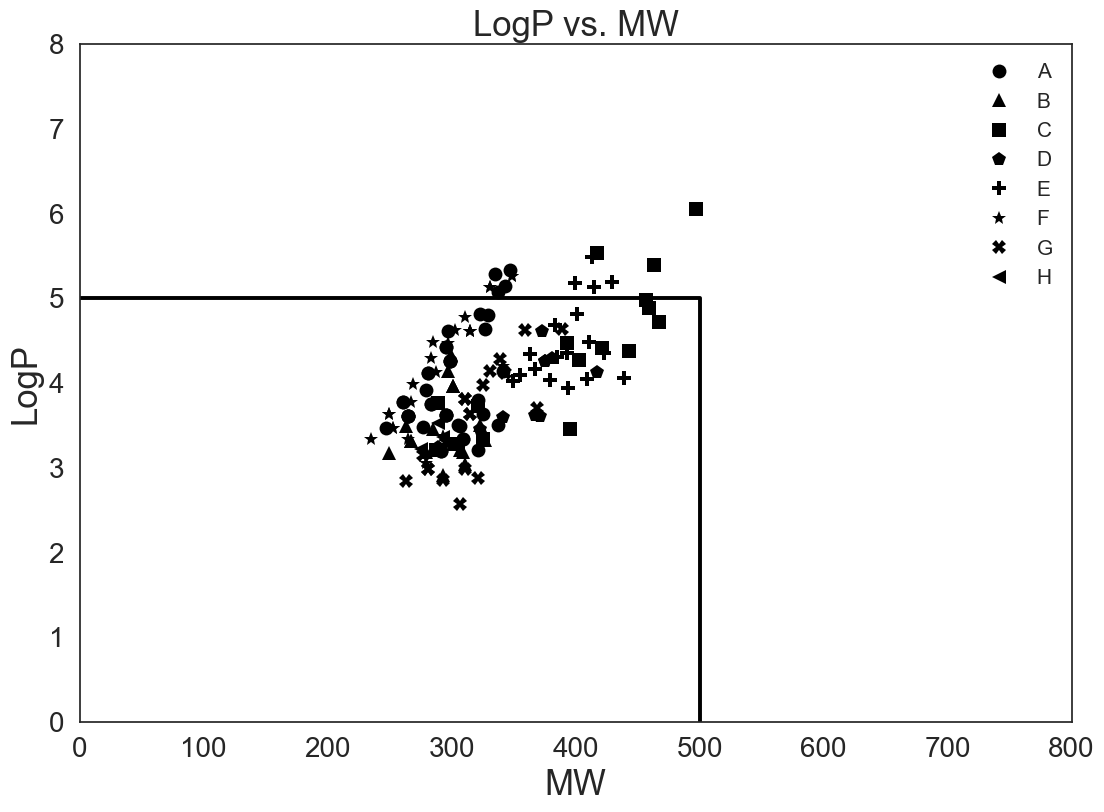

In [18]:
lip_classic();

In [19]:
time_run = time.time() - time_start
print('Runtime: {:.2f} minutes'.format(time_run/60))

Runtime: 13.95 minutes
